In [1]:
import numpy
from tqdm import tqdm
from pathlib import Path

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/harshamupparaju/Softwares/anaconda3/envs/CS_GY_6613_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path("./dogs-vs-cats-subset/subset/")
train_path = dataset_path / "train"
val_path = dataset_path / "validation"
test_path = dataset_path / "test"

## Data Augmentation
train_transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.RandomRotation(40),
                    torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                    torchvision.transforms.ToTensor(),
                ]
            )

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)

train_set = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
val_set = torchvision.datasets.ImageFolder(val_path, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_path, transform=transform)


In [32]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

classes = train_set.classes

# Model
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(128 * 14 * 14, 512),
    nn.ReLU(),
    nn.Linear(512, 2),
).to(device)

In [4]:
## Hyperparameters
num_epochs = 100
lr = 0.0001
momentum = 0.9

## Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)

In [5]:
## Training
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    accuracy = 0.0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (outputs.argmax(1) == labels).float().mean()

    ## Validation
    model.eval()
    val_accuracy = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).float().mean()

    ## Logging
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(accuracy.item()/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    val_accuracies.append(val_accuracy.item()/len(val_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy/len(val_loader)}")

100%|██████████| 63/63 [00:16<00:00,  3.78it/s]


Epoch 1, Loss: 0.7028914330497621, Accuracy: 0.5133928656578064, Val Loss: 0.6917222328484058, Val Accuracy: 0.5322265625


100%|██████████| 63/63 [00:17<00:00,  3.66it/s]


Epoch 2, Loss: 0.6911374027766879, Accuracy: 0.5173611640930176, Val Loss: 0.6879649106413126, Val Accuracy: 0.5546875


100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


Epoch 3, Loss: 0.6904418250871083, Accuracy: 0.5252976417541504, Val Loss: 0.6832982301712036, Val Accuracy: 0.580078125


100%|██████████| 63/63 [00:16<00:00,  3.77it/s]


Epoch 4, Loss: 0.6853702957668002, Accuracy: 0.555059552192688, Val Loss: 0.6820315327495337, Val Accuracy: 0.576171875


100%|██████████| 63/63 [00:16<00:00,  3.78it/s]


Epoch 5, Loss: 0.6860644618670145, Accuracy: 0.5615079402923584, Val Loss: 0.6795092914253473, Val Accuracy: 0.5771484375


100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


Epoch 6, Loss: 0.6722069269134885, Accuracy: 0.566964328289032, Val Loss: 0.6521437726914883, Val Accuracy: 0.5712890625


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]


Epoch 7, Loss: 0.6557249597140721, Accuracy: 0.5843254327774048, Val Loss: 0.6561116185039282, Val Accuracy: 0.5673828125


100%|██████████| 63/63 [00:16<00:00,  3.73it/s]


Epoch 8, Loss: 0.6534689201249017, Accuracy: 0.5858135223388672, Val Loss: 0.6485149096697569, Val Accuracy: 0.5751953125


100%|██████████| 63/63 [00:18<00:00,  3.39it/s]


Epoch 9, Loss: 0.6479600308433412, Accuracy: 0.591269850730896, Val Loss: 0.653293801471591, Val Accuracy: 0.57421875


100%|██████████| 63/63 [00:17<00:00,  3.66it/s]


Epoch 10, Loss: 0.6420208584694636, Accuracy: 0.5922619104385376, Val Loss: 0.6494729090481997, Val Accuracy: 0.5751953125


100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 11, Loss: 0.6458650335432992, Accuracy: 0.5803571939468384, Val Loss: 0.6616715593263507, Val Accuracy: 0.58203125


100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


Epoch 12, Loss: 0.6462703763492523, Accuracy: 0.6091270446777344, Val Loss: 0.6597972828894854, Val Accuracy: 0.591796875


100%|██████████| 63/63 [00:17<00:00,  3.63it/s]


Epoch 13, Loss: 0.6353567668369838, Accuracy: 0.6250000596046448, Val Loss: 0.6181961633265018, Val Accuracy: 0.6396484375


100%|██████████| 63/63 [00:16<00:00,  3.71it/s]


Epoch 14, Loss: 0.6113883942838699, Accuracy: 0.6473214626312256, Val Loss: 0.6802420848980546, Val Accuracy: 0.5615234375


100%|██████████| 63/63 [00:18<00:00,  3.50it/s]


Epoch 15, Loss: 0.6063785250224765, Accuracy: 0.6552579998970032, Val Loss: 0.6069145547226071, Val Accuracy: 0.65625


100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


Epoch 16, Loss: 0.5931755521940807, Accuracy: 0.6889881491661072, Val Loss: 0.6480618780478835, Val Accuracy: 0.6435546875


100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


Epoch 17, Loss: 0.6041658922793374, Accuracy: 0.6567460894584656, Val Loss: 0.5957884034141898, Val Accuracy: 0.6865234375


100%|██████████| 63/63 [00:17<00:00,  3.68it/s]


Epoch 18, Loss: 0.5858572134895931, Accuracy: 0.689484179019928, Val Loss: 0.5823780251666903, Val Accuracy: 0.7001953125


100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 19, Loss: 0.582939538690779, Accuracy: 0.6820436716079712, Val Loss: 0.5850119637325406, Val Accuracy: 0.6796875


100%|██████████| 63/63 [00:18<00:00,  3.45it/s]


Epoch 20, Loss: 0.581134681663816, Accuracy: 0.701388955116272, Val Loss: 0.6228309804573655, Val Accuracy: 0.6279296875


100%|██████████| 63/63 [00:16<00:00,  3.75it/s]


Epoch 21, Loss: 0.5841526611456795, Accuracy: 0.6845238208770752, Val Loss: 0.5927500259131193, Val Accuracy: 0.6640625


100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 22, Loss: 0.5605867074595557, Accuracy: 0.6989087462425232, Val Loss: 0.5707896677777171, Val Accuracy: 0.6904296875


100%|██████████| 63/63 [00:17<00:00,  3.65it/s]


Epoch 23, Loss: 0.5534343785709805, Accuracy: 0.713789701461792, Val Loss: 0.6603356692939997, Val Accuracy: 0.6640625


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]


Epoch 24, Loss: 0.5519278304917472, Accuracy: 0.7197421193122864, Val Loss: 0.5693012233823538, Val Accuracy: 0.701171875


100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Epoch 25, Loss: 0.5570865462696741, Accuracy: 0.713789701461792, Val Loss: 0.5726895844563842, Val Accuracy: 0.708984375


100%|██████████| 63/63 [00:17<00:00,  3.70it/s]


Epoch 26, Loss: 0.5456754305059948, Accuracy: 0.72817462682724, Val Loss: 0.5901405615732074, Val Accuracy: 0.6865234375


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]


Epoch 27, Loss: 0.5438975143054176, Accuracy: 0.7356151342391968, Val Loss: 0.583486270159483, Val Accuracy: 0.673828125


100%|██████████| 63/63 [00:16<00:00,  3.77it/s]


Epoch 28, Loss: 0.5403207067459349, Accuracy: 0.7291666865348816, Val Loss: 0.5766031350940466, Val Accuracy: 0.705078125


100%|██████████| 63/63 [00:17<00:00,  3.68it/s]


Epoch 29, Loss: 0.5308043332326979, Accuracy: 0.7321429252624512, Val Loss: 0.5921187521889806, Val Accuracy: 0.671875


100%|██████████| 63/63 [00:17<00:00,  3.70it/s]


Epoch 30, Loss: 0.5376727533718896, Accuracy: 0.7222222685813904, Val Loss: 0.5609643319621682, Val Accuracy: 0.681640625


100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 31, Loss: 0.5353184692443363, Accuracy: 0.730654776096344, Val Loss: 0.5950386058539152, Val Accuracy: 0.6640625


100%|██████████| 63/63 [00:17<00:00,  3.69it/s]


Epoch 32, Loss: 0.5386036227619837, Accuracy: 0.732638955116272, Val Loss: 0.548964305780828, Val Accuracy: 0.7099609375


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]


Epoch 33, Loss: 0.5185015776327678, Accuracy: 0.7430555820465088, Val Loss: 0.5436155162751675, Val Accuracy: 0.7197265625


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]


Epoch 34, Loss: 0.5065048559317513, Accuracy: 0.7430555820465088, Val Loss: 0.5264541385695338, Val Accuracy: 0.732421875


100%|██████████| 63/63 [00:17<00:00,  3.63it/s]


Epoch 35, Loss: 0.5045883627164931, Accuracy: 0.7559524178504944, Val Loss: 0.5310614546760917, Val Accuracy: 0.7333984375


100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 36, Loss: 0.48995393088885714, Accuracy: 0.756944477558136, Val Loss: 0.5370283024385571, Val Accuracy: 0.72265625


100%|██████████| 63/63 [00:19<00:00,  3.29it/s]


Epoch 37, Loss: 0.5034690371581486, Accuracy: 0.7490079998970032, Val Loss: 0.521141154691577, Val Accuracy: 0.74609375


100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 38, Loss: 0.5003026279192122, Accuracy: 0.75942462682724, Val Loss: 0.5338888643309474, Val Accuracy: 0.736328125


100%|██████████| 63/63 [00:18<00:00,  3.39it/s]


Epoch 39, Loss: 0.48070293806848075, Accuracy: 0.7678571939468384, Val Loss: 0.5287771373987198, Val Accuracy: 0.744140625


100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


Epoch 40, Loss: 0.46764204852164737, Accuracy: 0.780754029750824, Val Loss: 0.5338675305247307, Val Accuracy: 0.734375


100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 41, Loss: 0.47590395382472445, Accuracy: 0.7733135223388672, Val Loss: 0.5523645291104913, Val Accuracy: 0.7177734375


100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 42, Loss: 0.481579470729071, Accuracy: 0.7673611640930176, Val Loss: 0.48498891294002533, Val Accuracy: 0.755859375


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]


Epoch 43, Loss: 0.478474264580106, Accuracy: 0.7728174924850464, Val Loss: 0.5297336531803012, Val Accuracy: 0.7412109375


100%|██████████| 63/63 [00:16<00:00,  3.73it/s]


Epoch 44, Loss: 0.507787509570046, Accuracy: 0.7490079998970032, Val Loss: 0.5052713826298714, Val Accuracy: 0.7470703125


100%|██████████| 63/63 [00:17<00:00,  3.66it/s]


Epoch 45, Loss: 0.4484780246303195, Accuracy: 0.7847222685813904, Val Loss: 0.5195221244357526, Val Accuracy: 0.7236328125


100%|██████████| 63/63 [00:18<00:00,  3.38it/s]


Epoch 46, Loss: 0.4645098755283961, Accuracy: 0.773809552192688, Val Loss: 0.49473516270518303, Val Accuracy: 0.7548828125


100%|██████████| 63/63 [00:17<00:00,  3.67it/s]


Epoch 47, Loss: 0.4509895888585893, Accuracy: 0.7961310148239136, Val Loss: 0.49377004662528634, Val Accuracy: 0.7451171875


100%|██████████| 63/63 [00:18<00:00,  3.46it/s]


Epoch 48, Loss: 0.46966614562367637, Accuracy: 0.776289701461792, Val Loss: 0.49618459679186344, Val Accuracy: 0.7548828125


100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Epoch 49, Loss: 0.44864577646293335, Accuracy: 0.7827381491661072, Val Loss: 0.5098007190972567, Val Accuracy: 0.7294921875


100%|██████████| 63/63 [00:18<00:00,  3.40it/s]


Epoch 50, Loss: 0.46175173279784976, Accuracy: 0.7817460894584656, Val Loss: 0.5067197042517364, Val Accuracy: 0.7392578125


100%|██████████| 63/63 [00:17<00:00,  3.62it/s]


Epoch 51, Loss: 0.44189906853532035, Accuracy: 0.795138955116272, Val Loss: 0.5619130516424775, Val Accuracy: 0.7158203125


100%|██████████| 63/63 [00:17<00:00,  3.64it/s]


Epoch 52, Loss: 0.4532647000418769, Accuracy: 0.7827381491661072, Val Loss: 0.5072853751480579, Val Accuracy: 0.76171875


100%|██████████| 63/63 [00:20<00:00,  3.15it/s]


Epoch 53, Loss: 0.4196306100440404, Accuracy: 0.8070436716079712, Val Loss: 0.5119662210345268, Val Accuracy: 0.7509765625


100%|██████████| 63/63 [00:16<00:00,  3.72it/s]


Epoch 54, Loss: 0.4221890467026877, Accuracy: 0.795138955116272, Val Loss: 0.4923326107673347, Val Accuracy: 0.751953125


100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


Epoch 55, Loss: 0.42509469697399743, Accuracy: 0.8015873432159424, Val Loss: 0.49367885617539287, Val Accuracy: 0.75390625


100%|██████████| 63/63 [00:17<00:00,  3.70it/s]


Epoch 56, Loss: 0.42010571109870126, Accuracy: 0.8055555820465088, Val Loss: 0.4983883472159505, Val Accuracy: 0.75390625


100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 57, Loss: 0.4304354361125401, Accuracy: 0.807539701461792, Val Loss: 0.4947152575477958, Val Accuracy: 0.748046875


100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


Epoch 58, Loss: 0.40538425980106235, Accuracy: 0.819444477558136, Val Loss: 0.530572711257264, Val Accuracy: 0.7333984375


100%|██████████| 63/63 [00:18<00:00,  3.46it/s]


Epoch 59, Loss: 0.4244129407027411, Accuracy: 0.8010913133621216, Val Loss: 0.46417477913200855, Val Accuracy: 0.7783203125


100%|██████████| 63/63 [00:18<00:00,  3.46it/s]


Epoch 60, Loss: 0.3923119583300182, Accuracy: 0.8278770446777344, Val Loss: 0.5114237887319177, Val Accuracy: 0.734375


100%|██████████| 63/63 [00:17<00:00,  3.70it/s]


Epoch 61, Loss: 0.39575882563515313, Accuracy: 0.82192462682724, Val Loss: 0.5067710299044847, Val Accuracy: 0.7802734375


100%|██████████| 63/63 [00:17<00:00,  3.62it/s]


Epoch 62, Loss: 0.40242869158585864, Accuracy: 0.812004029750824, Val Loss: 0.4908815477974713, Val Accuracy: 0.7607421875


100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 63, Loss: 0.39132090007501935, Accuracy: 0.8214285969734192, Val Loss: 0.5011141863651574, Val Accuracy: 0.7822265625


100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 64, Loss: 0.39114204616773696, Accuracy: 0.814484179019928, Val Loss: 0.49360695108771324, Val Accuracy: 0.7548828125


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Epoch 65, Loss: 0.4123750998387261, Accuracy: 0.8134921193122864, Val Loss: 0.5039897602982819, Val Accuracy: 0.748046875


100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Epoch 66, Loss: 0.39621815038105795, Accuracy: 0.8199405074119568, Val Loss: 0.49068134697154164, Val Accuracy: 0.765625


100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch 67, Loss: 0.37584490293548223, Accuracy: 0.836309552192688, Val Loss: 0.5073923333548009, Val Accuracy: 0.7646484375


100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


Epoch 68, Loss: 0.3791714320107112, Accuracy: 0.8258929252624512, Val Loss: 0.5409181027207524, Val Accuracy: 0.7421875


100%|██████████| 63/63 [00:17<00:00,  3.70it/s]


Epoch 69, Loss: 0.3663947161227938, Accuracy: 0.8368055820465088, Val Loss: 0.4917241153307259, Val Accuracy: 0.7841796875


100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 70, Loss: 0.3685605071839832, Accuracy: 0.8382936716079712, Val Loss: 0.4487492684274912, Val Accuracy: 0.7822265625


100%|██████████| 63/63 [00:18<00:00,  3.33it/s]


Epoch 71, Loss: 0.3752982337323446, Accuracy: 0.8249008655548096, Val Loss: 0.4668046925216913, Val Accuracy: 0.7685546875


100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


Epoch 72, Loss: 0.35748061324868885, Accuracy: 0.8402778506278992, Val Loss: 0.4969488736242056, Val Accuracy: 0.7666015625


100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


Epoch 73, Loss: 0.34917452919577796, Accuracy: 0.8467262387275696, Val Loss: 0.4765882338397205, Val Accuracy: 0.7685546875


100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


Epoch 74, Loss: 0.35593387271676746, Accuracy: 0.8328373432159424, Val Loss: 0.5042500705458224, Val Accuracy: 0.78515625


100%|██████████| 63/63 [00:19<00:00,  3.29it/s]


Epoch 75, Loss: 0.3642878664864434, Accuracy: 0.8308532238006592, Val Loss: 0.4725809395313263, Val Accuracy: 0.775390625


100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


Epoch 76, Loss: 0.35457579602324774, Accuracy: 0.8462302088737488, Val Loss: 0.467720789834857, Val Accuracy: 0.7958984375


100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


Epoch 77, Loss: 0.32837227767422084, Accuracy: 0.8541666865348816, Val Loss: 0.4701239033602178, Val Accuracy: 0.7861328125


100%|██████████| 63/63 [00:19<00:00,  3.29it/s]


Epoch 78, Loss: 0.3348261359192076, Accuracy: 0.8581349849700928, Val Loss: 0.4849536055698991, Val Accuracy: 0.78515625


100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


Epoch 79, Loss: 0.34534803813412074, Accuracy: 0.8541666865348816, Val Loss: 0.4625437348149717, Val Accuracy: 0.806640625


100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 80, Loss: 0.3397897354194096, Accuracy: 0.8417659401893616, Val Loss: 0.4714162084273994, Val Accuracy: 0.7802734375


100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Epoch 81, Loss: 0.3404304929195888, Accuracy: 0.8422619700431824, Val Loss: 0.44340294459834695, Val Accuracy: 0.7861328125


100%|██████████| 63/63 [00:17<00:00,  3.67it/s]


Epoch 82, Loss: 0.3365592902141904, Accuracy: 0.855158805847168, Val Loss: 0.4896355390083045, Val Accuracy: 0.7646484375


100%|██████████| 63/63 [00:18<00:00,  3.44it/s]


Epoch 83, Loss: 0.30630594089863794, Accuracy: 0.8670635223388672, Val Loss: 0.4591309300158173, Val Accuracy: 0.7890625


100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


Epoch 84, Loss: 0.33197786528912804, Accuracy: 0.848214328289032, Val Loss: 0.47686525946483016, Val Accuracy: 0.77734375


100%|██████████| 63/63 [00:17<00:00,  3.69it/s]


Epoch 85, Loss: 0.32118100046165404, Accuracy: 0.8581349849700928, Val Loss: 0.4554544279817492, Val Accuracy: 0.7919921875


100%|██████████| 63/63 [00:17<00:00,  3.67it/s]


Epoch 86, Loss: 0.3306659146670311, Accuracy: 0.8462302088737488, Val Loss: 0.5479847628157586, Val Accuracy: 0.7412109375


100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Epoch 87, Loss: 0.297930704814101, Accuracy: 0.8759921193122864, Val Loss: 0.4913718868046999, Val Accuracy: 0.7802734375


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Epoch 88, Loss: 0.31009705932367415, Accuracy: 0.86259925365448, Val Loss: 0.4636766945477575, Val Accuracy: 0.7880859375


100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


Epoch 89, Loss: 0.2988561323237798, Accuracy: 0.874504029750824, Val Loss: 0.5836018059635535, Val Accuracy: 0.7421875


100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


Epoch 90, Loss: 0.3251002466394788, Accuracy: 0.8645833730697632, Val Loss: 0.5003361019771546, Val Accuracy: 0.7578125


100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 91, Loss: 0.3272085539878361, Accuracy: 0.8611111640930176, Val Loss: 0.49997018452268094, Val Accuracy: 0.794921875


100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 92, Loss: 0.2868427546724441, Accuracy: 0.876984179019928, Val Loss: 0.47497627907432616, Val Accuracy: 0.7861328125


100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 93, Loss: 0.33061424630974967, Accuracy: 0.8526785969734192, Val Loss: 0.4835979475174099, Val Accuracy: 0.78515625


100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 94, Loss: 0.2795934994069357, Accuracy: 0.8834325671195984, Val Loss: 0.5154183700215071, Val Accuracy: 0.7822265625


100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 95, Loss: 0.2696445668264041, Accuracy: 0.8854167461395264, Val Loss: 0.5998560009757057, Val Accuracy: 0.7841796875


100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Epoch 96, Loss: 0.29809863522412283, Accuracy: 0.8774802088737488, Val Loss: 0.48185668466612697, Val Accuracy: 0.796875


100%|██████████| 63/63 [00:19<00:00,  3.29it/s]


Epoch 97, Loss: 0.29816513626821456, Accuracy: 0.874504029750824, Val Loss: 0.5759597346186638, Val Accuracy: 0.7783203125


100%|██████████| 63/63 [00:18<00:00,  3.39it/s]


Epoch 98, Loss: 0.28258220496631803, Accuracy: 0.876984179019928, Val Loss: 0.5147041028831154, Val Accuracy: 0.7861328125


100%|██████████| 63/63 [00:17<00:00,  3.69it/s]


Epoch 99, Loss: 0.27498207489649457, Accuracy: 0.8918651342391968, Val Loss: 0.46574659552425146, Val Accuracy: 0.79296875


100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 100, Loss: 0.27483208051749636, Accuracy: 0.8839285969734192, Val Loss: 0.516541691031307, Val Accuracy: 0.7998046875


In [6]:
## Save the model
torch.save(model.state_dict(), "model.pth")

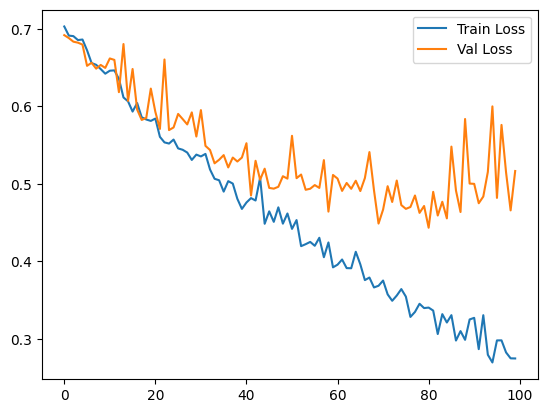

In [7]:
## Plotting Losses
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

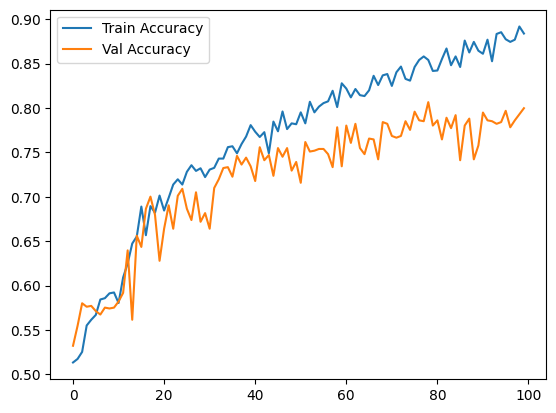

In [19]:
## Plotting Accuracies
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.show()

# Explainer Algorithms
## Integrated Gradients

Integrated Gradients is a feature attribution based Exaplainable AI technique. Integrated Gradients make it possible to examine the inputs of a deep learning model on their importance for the output. In particular it helps us answer the question: "Which pixels in this input image drove the model's classification of the image". This method can be easily implemented in PyTorch using the Captum library.

[**Integrated Gradients**](https://captum.ai/api/integrated_gradients.html) is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model's output with respect to the inputs.

In our case, we're going to be taking a specific element of the output vector - that is, the one indicating the model's confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we'll use the visualization tools in Captum to give a helpful representation of the importance map. Captum's `visualize_image_attr()` function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.

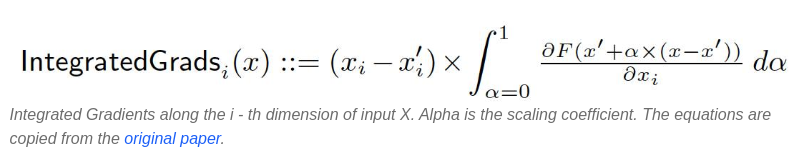

tensor([[-0.0208, -0.0002]], device='cuda:0', grad_fn=<AddmmBackward0>)


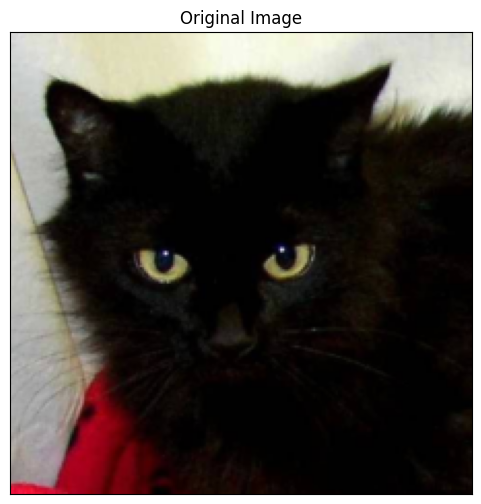

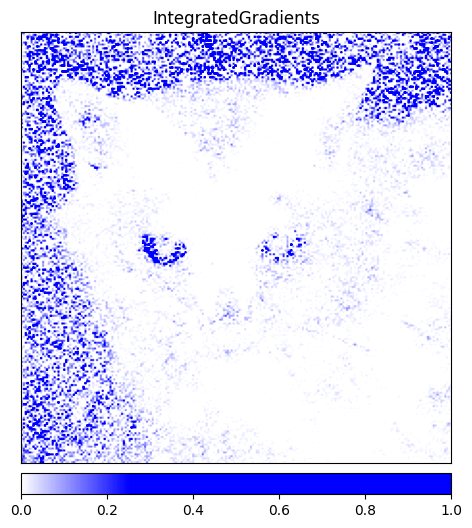

In [37]:
model.eval()

# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Get a batch of data
image, label = next(iter(test_loader))

## Pass the images to the model
output = model(image.to(device))
print(output)
# Get the attributions
attributions_ig = integrated_gradients.attribute(image.to(device), target=output.argmax().item(), n_steps=200)

# Show the original iamge for comparision with the attributions
_ = viz.visualize_image_attr(None, image[0].cpu().permute(1,2,0).numpy(), method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                    [(0, '#ffffff'),
                                                    (0.25, '#0000ff'),
                                                    (1, '#0000ff')], N=256)

# _ = viz.visualize_image_attr(attributions_ig[0].cpu().numpy(), image[0].cpu().numpy(), method="heat_map", cmap=default_cmap, show_colorbar=True, sign='positive', title="Integrated Gradients")
_ = viz.visualize_image_attr(numpy.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             numpy.transpose(image.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='IntegratedGradients')

The above iamge, shows that the model pays attention to teh outline of the cat and the eyes of the cat as well in this particular case, which lead it to classify the image as a cat.

## Grad-CAM

Grad-CAM is a Layer Attribution algorithm , which let's su answer the questions like: "How is the activation map output by this convolutional layer correlated to my input image?". This can also be implemented easily in Pytorch using Captum library.

**Layer Attribution** allows you to attribute the activity of hidden layers within your model to features of your input. Below, we'll use a layer attribution algorithm to examine the activity of one of the convolutional layers within our model.

GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled and used to mask the input.

Layer attribution is set up similarly to input attribution, except that in addition to the model, you must specify a hidden layer within the model that you wish to examine. As above, when we call `attribute()`, we specify the target class of interest.

In [38]:
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=25088, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=2, bias=True)
)

The above cell's output is our model architecture, for seeing the layer names and their indices. We can use this information to select the layer we want to examine. I have picked layer 9: `(9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))`

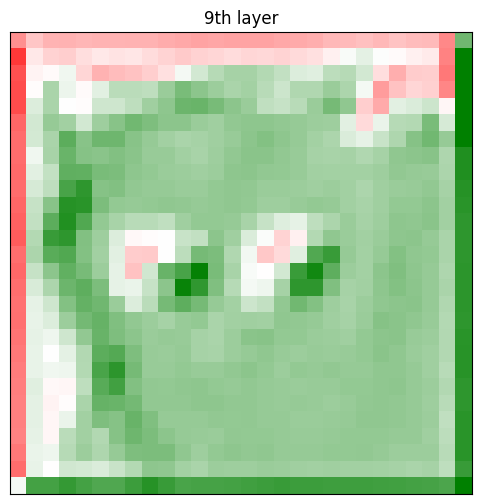

In [51]:
layer_gradcam = LayerGradCam(model, model[9]) ## Here we initialize the LayerGradCam object, we pass it our model and the hidden layer which we want to examine
attributions_lgc = layer_gradcam.attribute(image.to(device), target=output.argmax().item()) ## We give the layer_gradcam object our input and output and ask it for attributions

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign='all',
                             title='9th layer')

This image shows which areas of the image the model is paying attention to when classifying it as a cat. The model is focusing on the outline of the cat, eyes, and some other parths of the cat face(marked as green) which are important features for classifying the image as a cat.

We can do better than this. Since the output of a convolutional layer is spatically correlated to the input, we can unsample the activation map and directly compare it with the input image instead. This will give us a better understanding of the model's attention.

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


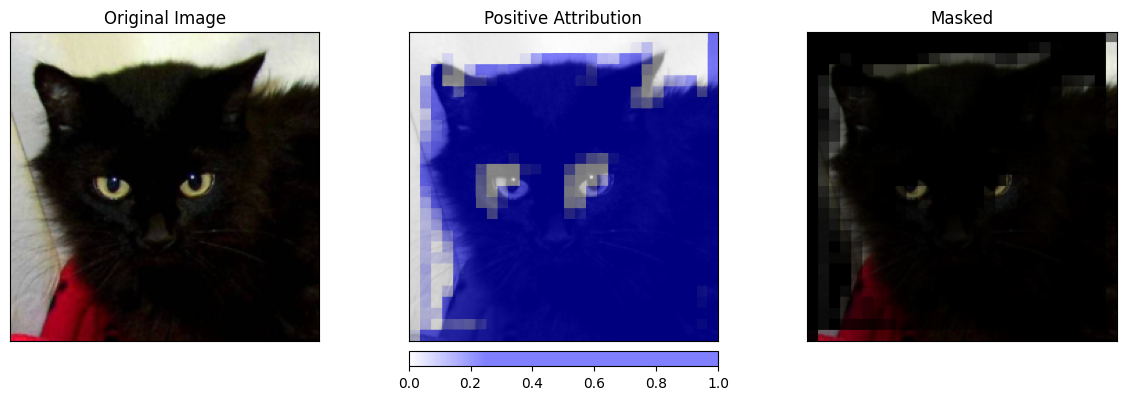

In [50]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, image.shape[2:]) ## We upsample the attributions to the size of the input image

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(image.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                        image[0].cpu().permute(1,2,0).numpy(),
                                        ["original_image", "blended_heat_map", "masked_image"],
                                        ["all", "positive", "positive"],
                                        show_colorbar=True,
                                        titles=["Original Image", "Positive Attribution", "Masked"],
                                        cmap=default_cmap,
                                        fig_size=(12, 4)
                                        )



As can be seen from the above results, the 9th layer focuses on the eyes of the cat, the outline of the cat, and the face of the cat. This is a good indication that the model is focusing on the right features to classify the image as a cat.